In [19]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import csv

from repe import repe_pipeline_registry, PCARepReader

repe_pipeline_registry()

from honesty.utils import (
    honesty_function_dataset,
    plot_lat_scans,
    plot_detection_results,
)

rep-reading is already registered. Overwriting pipeline for task rep-reading...
rep-control is already registered. Overwriting pipeline for task rep-control...


In [2]:
model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.2"
dataset_name = "facts_true_false"
device = (
    "cuda"
    if torch.cuda.is_available()
    else (torch.device("mps") if torch.backends.mps.is_available() else "cpu")
)

model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path, torch_dtype=torch.float16, device_map=device
)
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False
)
tokenizer.pad_token_id = 0

rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = "pca"
rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

user_tag = "[INST]"
assistant_tag = "[/INST]"

data_path = f"./data/{dataset_name}.csv"
dataset = honesty_function_dataset(data_path, tokenizer, user_tag, assistant_tag)

honesty_rep_reader = rep_reading_pipeline.get_directions(
    dataset["train"]["data"],
    rep_token=rep_token,
    hidden_layers=hidden_layers,
    n_difference=n_difference,
    train_labels=dataset["train"]["labels"],
    direction_method=direction_method,
    batch_size=32,
)

Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


Train data: 1024
Test data: 512


In [7]:
print(hidden_layers)

[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]


processing sentence:  Neptune has the calmest winds in the solar system. Mars has the largest volcano, Olympus Mons. Fossils provide evidence of past life on Earth.


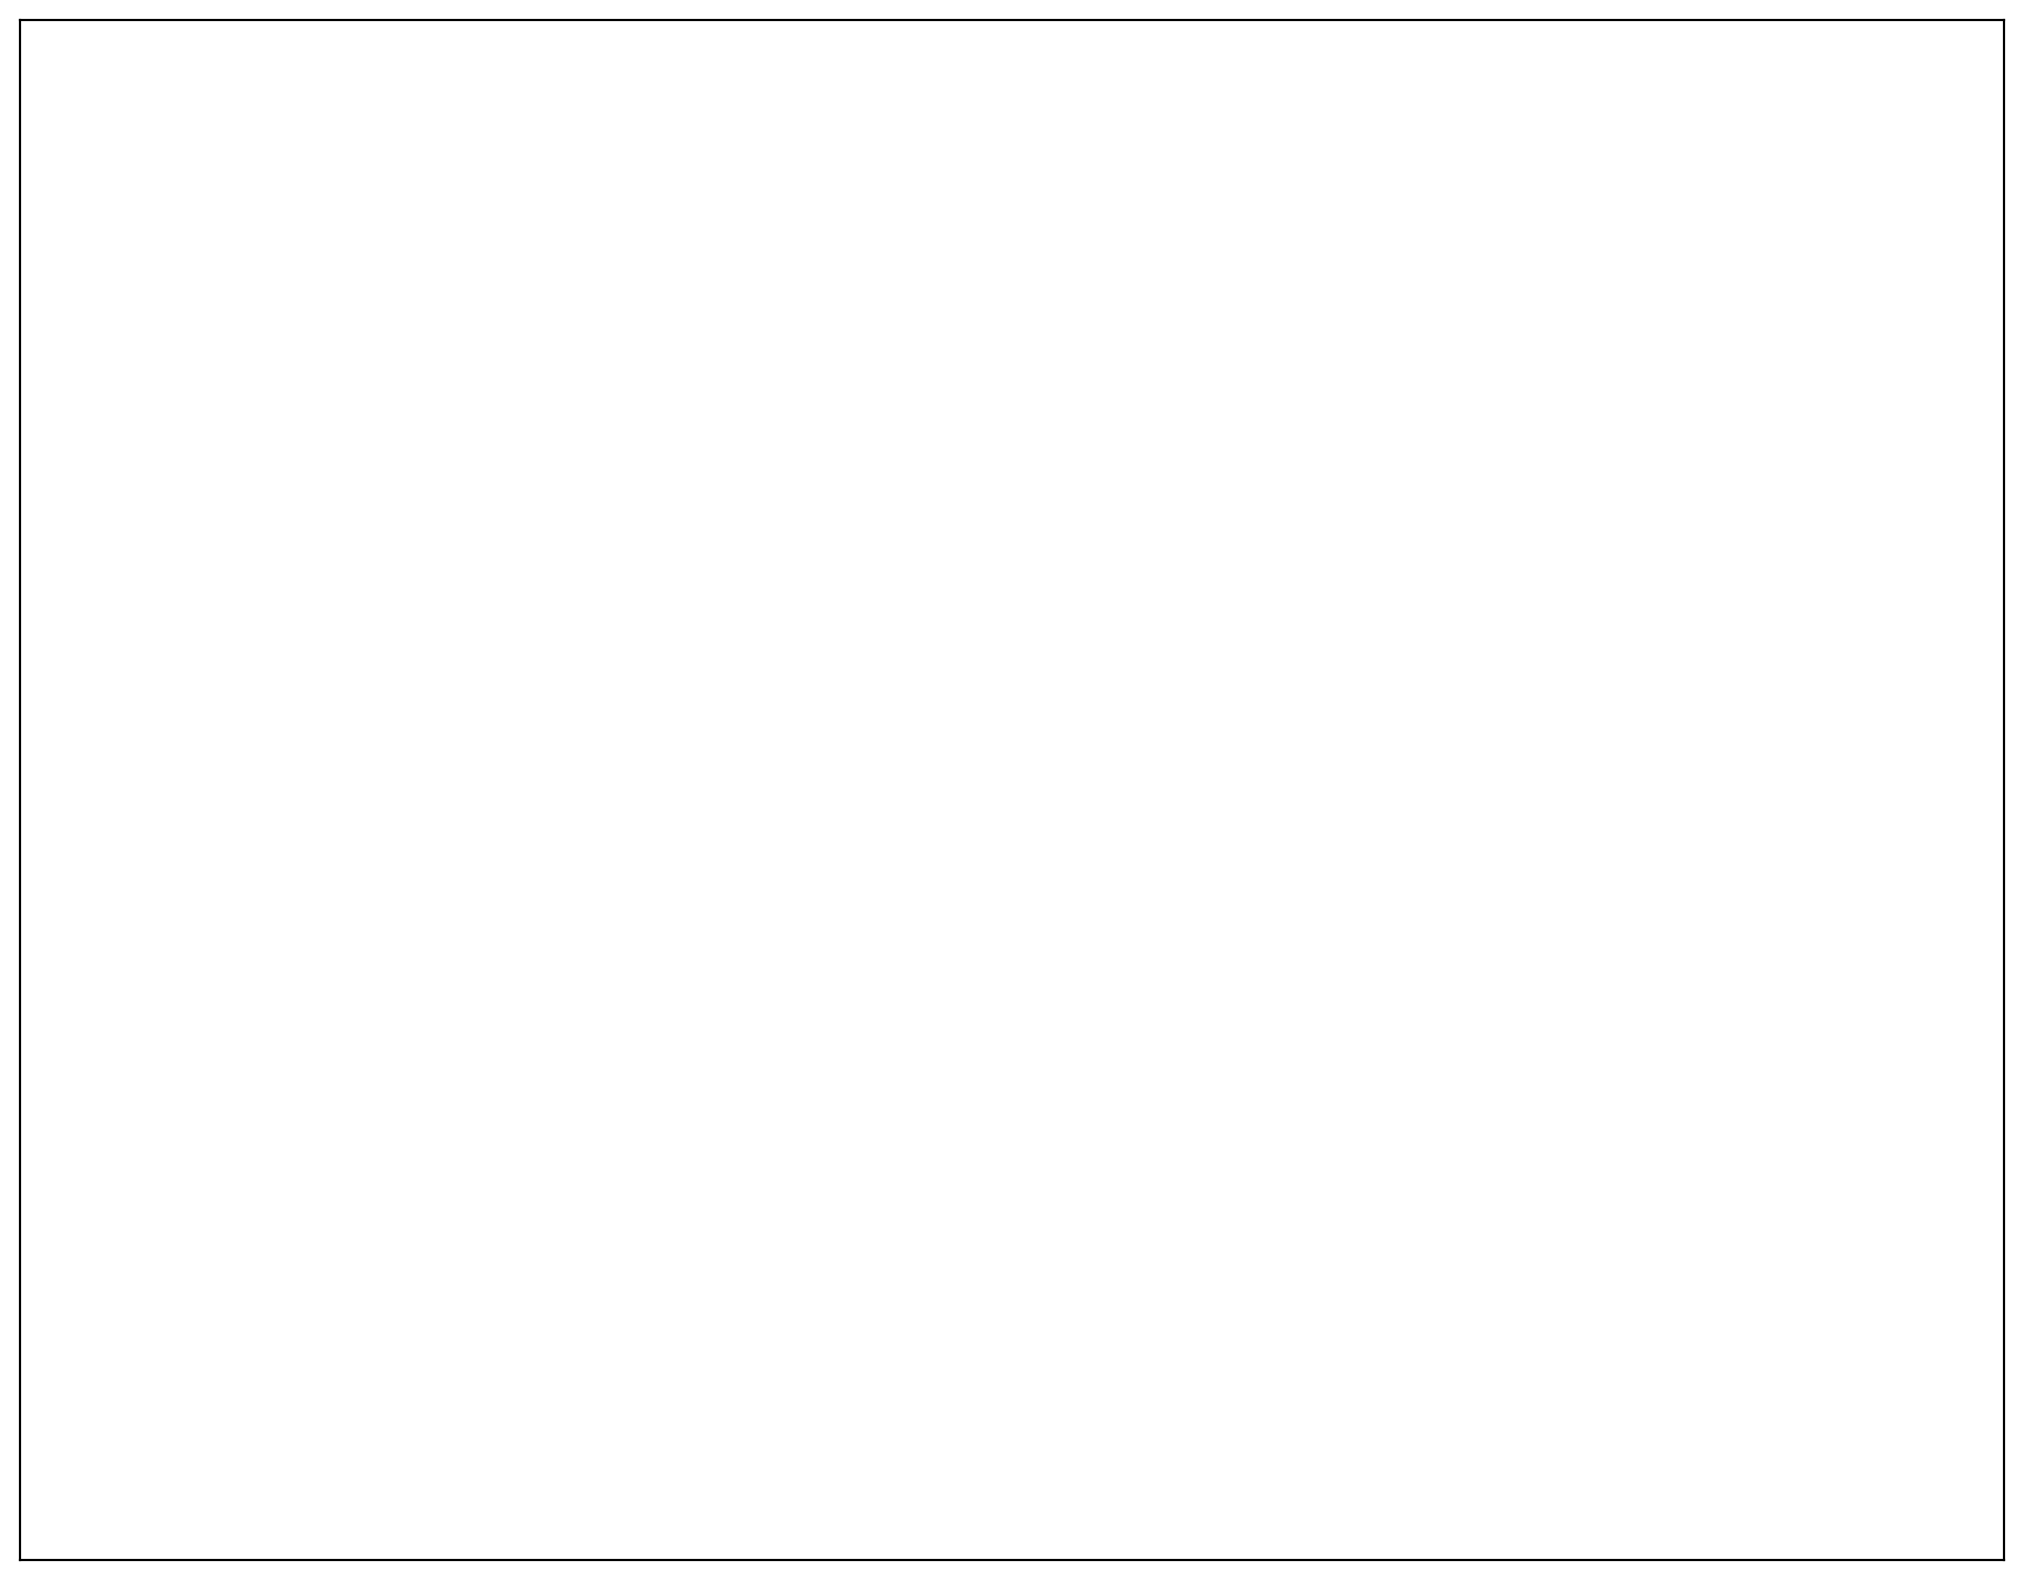

In [26]:
data = csv.reader(open("./data/activations/association.csv", "r"), delimiter=",")

layers = range(-15, -31, -1)
rep_reader_scores_dict = {}
rep_reader_scores_mean_dict = {}

for i, row in enumerate(data):
    # Process each row of data here
    sentence = row[1]
    labels = row[2]

    print("processing sentence: ", sentence)

    input_ids = tokenizer.tokenize(sentence)

    results = []

    for ice_pos in range(len(input_ids)):
        ice_pos = -len(input_ids) + ice_pos  # start at -len(input_ids) and go to -1
        H_tests = rep_reading_pipeline(
            [sentence],
            rep_reader=honesty_rep_reader,
            rep_token=ice_pos,
            hidden_layers=hidden_layers,
        )
        results.append(H_tests)

    honesty_scores = (
        []
    )  # stores honesty scores for all layers across all token positions
    honesty_scores_means = (
        []
    )  # stores mean score across specified layers for each token position
    for pos in range(len(results)):
        tmp_scores = []  # scores for specified layers (-15 - -34)
        tmp_scores_all = []  # scores for all layers
        for layer in hidden_layers:
            tmp_scores_all.append(
                results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0]
            )  # gets the rep reader value for the layer, multiplied by direction gives the actual score
            if layer in layers:
                tmp_scores.append(
                    results[pos][0][layer][0]
                    * honesty_rep_reader.direction_signs[layer][0]
                )
        honesty_scores.append(tmp_scores_all)
        honesty_scores_means.append(np.mean(tmp_scores))

    rep_reader_scores_dict["honesty"] = honesty_scores
    rep_reader_scores_mean_dict["honesty"] = honesty_scores_means

    plot_detection_results(input_ids, rep_reader_scores_mean_dict, 0.0)